# 2D Convolutional Neural Networks for ECG Classification
* Model 1 trained using 28 x 28 sized images
* Model 2 trained using 128 x 128 sized images

**Principal Component Analysis performed for both models using variance >= 95%**

### Metric
The metric will be **Accuracy.** We will also look at **Precision, Recall/Sensitivity,** and **Specificity**

**Original 2D Convolutional Neural Network Architecture:** 

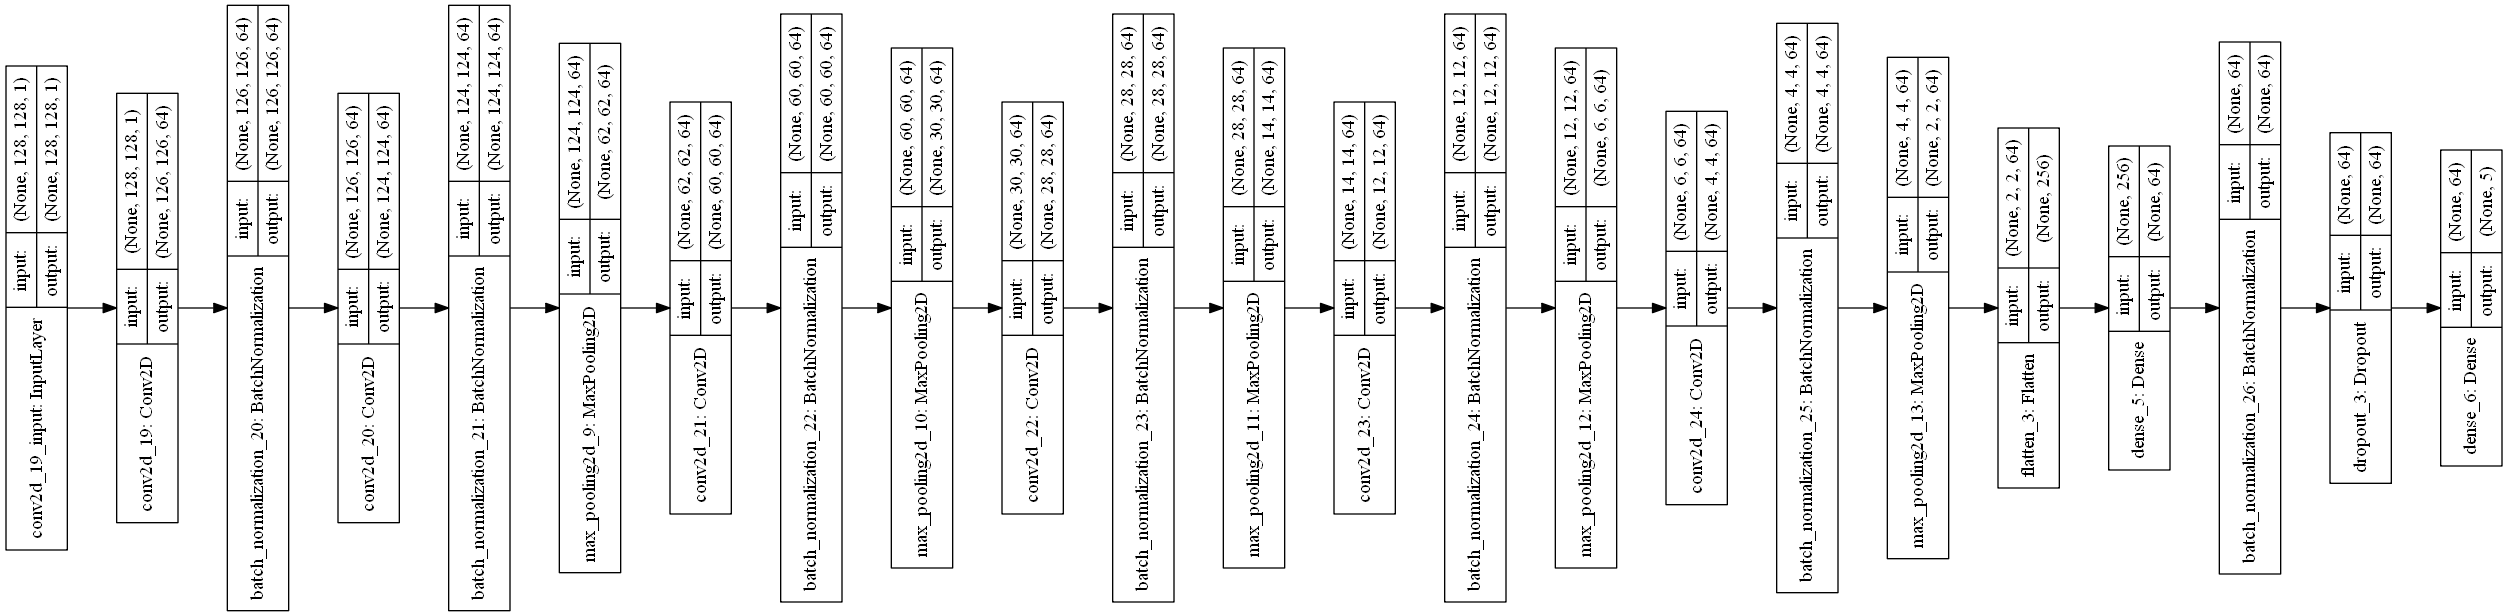

**Simplified and most accurate 2D Convolutional Neural Network Architecture:**

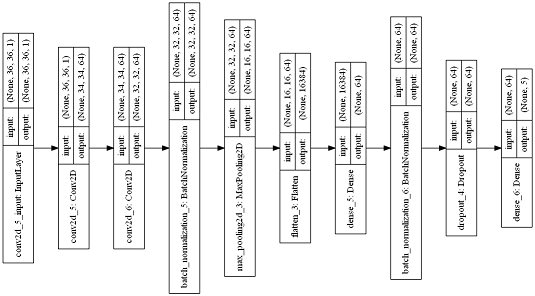

### Original dataset:

* The dataset is composed of two collections of heartbeat signals derived from two datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database.
* Dataset Link: https://www.kaggle.com/shayanfazeli/heartbeat?select=mitbih_train.csv       

* Dataset is sampled to 10,000
* ECG signal data points converted to images and saved to directory
* ECG images extracted and saved to csv file 
* Sampled and transfromed images joined with labels to complete csv file  

Code for preprocessing the dataset can be found in the notebook: ECG_Heartbeat_Classification_2Dconv.02.etl

# Imports

In [2]:
# imports
import numpy as np
import pandas as pd
import os
#!pip install pandas-profiling
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import graphviz
%matplotlib inline

np.random.seed(123)

#!pip install scikit-learn
import sklearn
import scikitplot as skplt
import sklearn.feature_selection
from sklearn.preprocessing import label_binarize,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import tensorflow as tf
import keras
from keras.utils import plot_model
from keras import regularizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Load Data

In [2]:
# Sampled dataset
## ECG_imgs28_sampled.csv containing 28x28 scale images
### ECG_imgs_sampled.csv is for end classification and contains 128x128 scale images

ECG_imgs28_sampled = pd.read_csv('ECG_imgs28_sampled.csv')
ECG_imgs28_sampled.head(3)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,254.0,255.0,255.0,253.0,255.0,255.0,254.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0
1,255.0,254.0,255.0,255.0,253.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0
2,255.0,255.0,252.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0


In [3]:
ECG_imgs28_sampled.shape

(9999, 785)

In [4]:
#Split features and targets and make copy of df
X = ECG_imgs28_sampled.drop('label',axis=1).copy() 
y = ECG_imgs28_sampled['label'].copy()

In [5]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({0.0: 8330, 4.0: 712, 2.0: 649, 1.0: 236, 3.0: 72})


In [6]:
#Class distributions
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=8330 (83.308%)
Class=2, n=649 (6.491%)
Class=4, n=712 (7.121%)
Class=1, n=236 (2.360%)
Class=3, n=72 (0.720%)


## Balance the dataset
* Random Undersampling
* SMOTE - Synthetic Minority Oversampling Technique

In [7]:
# Random Undersampling

from imblearn.under_sampling import RandomUnderSampler

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy= {0:2000})

# transform the dataset
X, y = undersample.fit_resample(X, y)

# summarize class distribution
#print(Counter(y))



# summarize class distribution

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
#pyplot.bar(counter.keys(), counter.values())
#pyplot.show()

Class=0, n=2000 (54.511%)
Class=1, n=236 (6.432%)
Class=2, n=649 (17.689%)
Class=3, n=72 (1.962%)
Class=4, n=712 (19.406%)


In [8]:
#SMOTE
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=2000 (20.000%)
Class=1, n=2000 (20.000%)
Class=2, n=2000 (20.000%)
Class=3, n=2000 (20.000%)
Class=4, n=2000 (20.000%)


In [9]:
print(X.shape)
print(y.shape)

(10000, 784)
(10000,)


In [10]:
# Normalize
X /= 255

In [11]:
X = np.array(X)
print(X.shape)

(10000, 784)


## Train -Test Split 

In [12]:
# Using 90% for training and 10% for testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0) # try.85
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [13]:
X_train.shape

(9000, 784)

In [14]:
X_test.shape

(1000, 784)

In [15]:
y_train.shape

(9000,)

In [16]:
y_test.shape

(1000,)

## PCA

In [17]:
from sklearn.decomposition import PCA

# Make an instance of the Model using 95% variance (.95) for example
# use square root of components for reshaping
# round up if float and rerun pca with new n_components

pca = PCA(196)

In [18]:
# Fit pca on training set
pca.fit(X_train)

print('Number of components:',pca.n_components_)

Number of components: 196


In [19]:
#Apply the mapping (transform) to both the training set and the test set
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [20]:
print(X_train.shape)
print(X_test.shape)

(9000, 196)
(1000, 196)


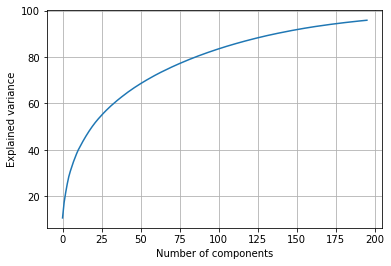

In [23]:
# Scree plot

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')
plt.grid()

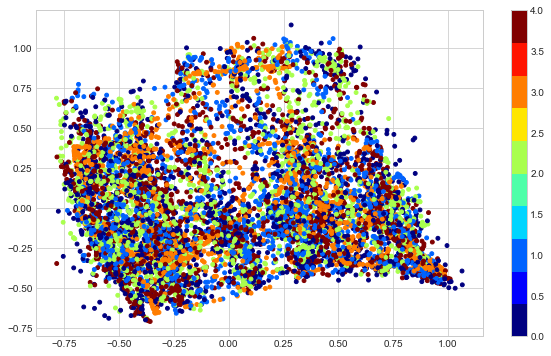

In [24]:
# Scatterplot (train set)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_train[:,0], X_train[:,1], s = 15,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.show()

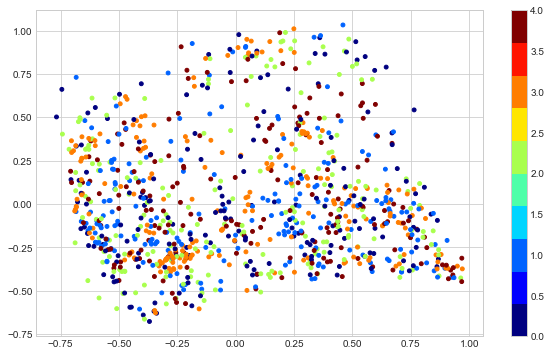

In [25]:
# Scatterplot (train set)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_test[:,0], X_test[:,1], s = 15,
            cmap = c_map , c = y_test)
plt.colorbar()
plt.show()

In [26]:
# Explained Variance
print(pca.explained_variance_)

[0.22120766 0.13570784 0.08771679 0.07608569 0.06518742 0.04885656
 0.04306232 0.03998521 0.03661581 0.03460305 0.03147348 0.02617131
 0.02559519 0.02526026 0.02406345 0.02319537 0.02275817 0.02105267
 0.02047013 0.01984864 0.01868021 0.01800039 0.01697318 0.01613382
 0.01560993 0.015385   0.01454001 0.01446874 0.01377442 0.01341095
 0.01324129 0.01299326 0.01223327 0.01199909 0.01184388 0.01170051
 0.01133183 0.01097714 0.01085035 0.01063302 0.01055321 0.01042385
 0.01025054 0.00988089 0.0096034  0.00952723 0.00935888 0.00908024
 0.00897034 0.00886806 0.00855548 0.00848104 0.00840306 0.00811865
 0.00801009 0.0079479  0.00785657 0.00777741 0.00765245 0.00757584
 0.00747099 0.00723293 0.00711136 0.00696549 0.00680494 0.00674384
 0.00671213 0.00666536 0.0066545  0.00652251 0.00644094 0.0063317
 0.00624003 0.00621057 0.00611335 0.00601723 0.00592929 0.00591716
 0.00582305 0.00572017 0.00568735 0.00562039 0.00552298 0.00545266
 0.00541957 0.00537639 0.00533478 0.00528551 0.00515888 0.00507

## Reshaping for Use in 2D Conv

In [27]:
# dimensions from square root of pca

X_train = X_train.reshape(-1, 14, 14, 1) 
print(X_train.shape)

X_test = X_test.reshape(-1, 14, 14, 1) 
print(X_test.shape)

(9000, 14, 14, 1)
(1000, 14, 14, 1)


In [28]:
# Encode the labels

y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(9000, 5)
(1000, 5)


## Class Labels

In [29]:
# For class label mapping

class_label = {
    0: 'N - Normal',
    1: 'S - Atrial premature',
    2: 'V - Premature ventricular contraction',
    3: 'F - Fusion of ventricular and normal',
    4: 'Q - Paced Unclassifiable'
}

# Model 1

## 2D Conv Model - Train on 28 x 28 scale images

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 12, 12, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                204864    
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)               

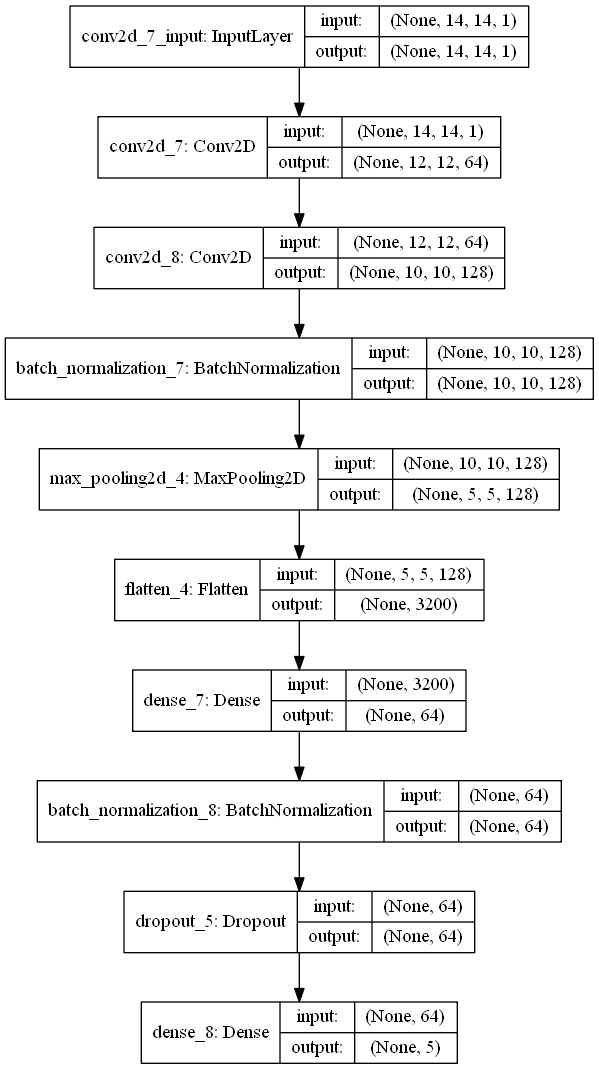

In [37]:
from numpy.random import seed
seed(42)

batch_size = 64  
num_classes = 5 
epochs = 50   
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10, restore_best_weights=True,
 verbose=1)

# Note: if using 28x28 images the MaxPooling layers reduce diminsionality too much and cause an error. Trim as needed.

def create_cnv():
    
    model = Sequential()
    model.add(Conv2D(64,(3,3),activation='elu', input_shape=(14,14,1)))
    model.add(Conv2D(128,(3,3),activation='elu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))   
    model.add(Flatten())
    model.add(Dense(64,activation='elu')) 
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    model.add(Dense(5,activation='softmax',))

    model.compile(loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy'])
    return model

model = create_cnv()
model.summary()
plot_model(model, to_file='model_1_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es], 
                  verbose=1,
                  validation_split = 0.1,  
                  validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
save_path = "ker_BEST_2Hidden_ECG_28_model.%s.h5" % (score[1])
            
model.save(save_path)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 23s 3ms/step - loss: 1.5014 - accuracy: 0.4629 - val_loss: 1.5571 - val_accuracy: 0.3930
Epoch 2/50
9000/9000 [==============================] - 21s 2ms/step - loss: 0.9440 - accuracy: 0.6494 - val_loss: 1.6341 - val_accuracy: 0.2200
Epoch 3/50
9000/9000 [==============================] - 21s 2ms/step - loss: 0.7229 - accuracy: 0.7241 - val_loss: 2.0014 - val_accuracy: 0.2860
Epoch 4/50
9000/9000 [==============================] - 22s 2ms/step - loss: 0.5986 - accuracy: 0.7766 - val_loss: 0.8700 - val_accuracy: 0.6400
Epoch 5/50
9000/9000 [==============================] - 21s 2ms/step - loss: 0.5284 - accuracy: 0.8034 - val_loss: 0.5852 - val_accuracy: 0.7820
Epoch 6/50
9000/9000 [==============================] - 23s 3ms/step - loss: 0.4389 - accuracy: 0.8380 - val_loss: 0.6226 - val_accuracy: 0.7670
Epoch 7/50
9000/9000 [==============================] - 23s 3ms/step - loss: 0.381

## Saved Models

In [40]:
ls -ltr ker_*

 Volume in drive C is Windows
 Volume Serial Number is 901D-281F

 Directory of C:\Users\celie


 Directory of C:\Users\celie

09/13/2021  02:37 PM         3,410,880 ker_BEST_2Hidden_ECG_28_model.0.8659999966621399.h5
09/08/2021  02:37 PM         1,825,800 ker_BEST_Single_ECG_28_model.0.8610000014305115.h5
09/10/2021  03:35 PM        13,091,232 ker_ECG_BEST_2Hidden_128_model.0.8949999809265137.h5
09/10/2021  02:49 PM        14,261,136 ker_ECG_BEST_Single_128_model.0.8769999742507935.h5
               4 File(s)     32,589,048 bytes
               0 Dir(s)  122,894,639,104 bytes free


## Model fitting summary

In [41]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_c2d = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 12, 12, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                204864    
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)               

In [42]:
# Convert labels from one hot encoding for classification report
y_test=np.argmax(y_test, axis=1)
y_test[1]

0

In [43]:
print(classification_report(y_test.astype(int), prediction_c2d))

              precision    recall  f1-score   support

           0       0.74      0.63      0.68       188
           1       0.93      0.98      0.96       211
           2       0.82      0.82      0.82       201
           3       0.97      1.00      0.99       215
           4       0.82      0.88      0.85       185

    accuracy                           0.87      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.87      0.86      1000



Text(0.5, 19.5, 'Predicted Class')

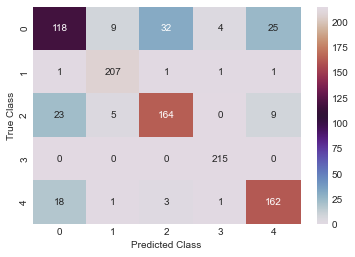

In [44]:
cm = confusion_matrix(y_test,prediction_c2d)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

### Performance metrics from confusion matrix 

In [45]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.94827586 0.98098859 0.95494368 0.99235669 0.95705521]
Specificity Mean: 0.9667240074892748
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.62765957 0.98104265 0.8159204  1.         0.87567568]
Recall/Sensitivity Mean: 0.8600596604364295
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.7375     0.93243243 0.82       0.97285068 0.82233503]
Precision Mean: 0.857023627309235


## Visualize training and test histories

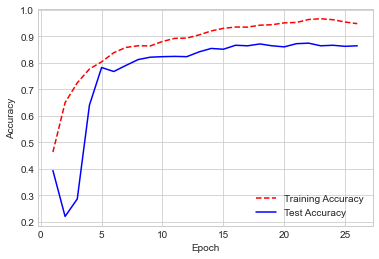

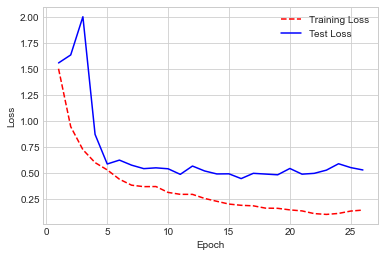

In [46]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [47]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.968216 (macro),
0.969452 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.969580 (macro),
0.970980 (weighted by prevalence)


## ROC plot

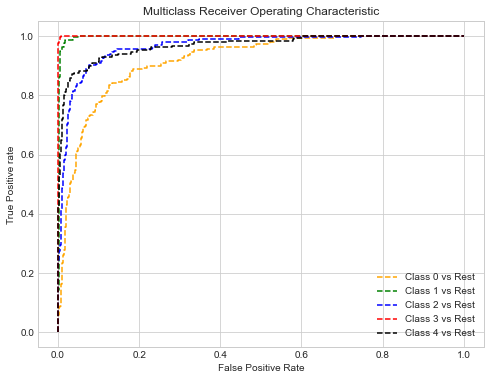

In [48]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

In [49]:
# Predict and plot example
prediction_cplx = model.predict_classes(X_test)
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


The Predicted Event is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


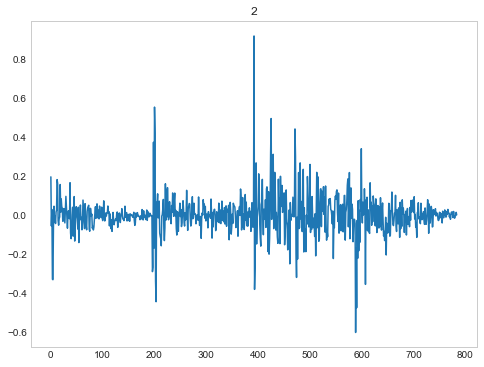

In [50]:
# Test plot

X_test = X_test.reshape(-1, 784)
# X_test.shape
print('The Predicted Event is:',prediction_cplx[8])
print('Class:',class_label)
plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8])
plt.title( prediction_cplx[8]) 
plt.grid()
plt.show()


# Model 2

## 2D Conv Model - Train using 128 x 128 scale images

## Load Data

In [3]:
# Sampled dataset
### ECG_imgs_sampled.csv contains 128x128 scale images

ECG_imgs_sampled = pd.read_csv('ECG_imgs_sampled.csv')
ECG_imgs_sampled.head(3)

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,label
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0


In [4]:
ECG_imgs_sampled.shape

(9999, 16385)

In [5]:
#Split features and targets and make copy of df
X = ECG_imgs_sampled.drop('label',axis=1).copy() 
y = ECG_imgs_sampled['label'].copy()

In [6]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({0.0: 8330, 4.0: 712, 2.0: 649, 1.0: 236, 3.0: 72})


In [7]:
#Class distributions
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=8330 (83.308%)
Class=2, n=649 (6.491%)
Class=4, n=712 (7.121%)
Class=1, n=236 (2.360%)
Class=3, n=72 (0.720%)


## Balance the dataset
* Random Undersampling
* SMOTE - Synthetic Minority Oversampling Technique

In [8]:
# Random Undersampling

from imblearn.under_sampling import RandomUnderSampler

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy= {0:2000})

# transform the dataset
X, y = undersample.fit_resample(X, y)

# summarize class distribution
#print(Counter(y))



# summarize class distribution

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
#pyplot.bar(counter.keys(), counter.values())
#pyplot.show()

Class=0, n=2000 (54.511%)
Class=1, n=236 (6.432%)
Class=2, n=649 (17.689%)
Class=3, n=72 (1.962%)
Class=4, n=712 (19.406%)


In [9]:
#SMOTE
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=2000 (20.000%)
Class=1, n=2000 (20.000%)
Class=2, n=2000 (20.000%)
Class=3, n=2000 (20.000%)
Class=4, n=2000 (20.000%)


In [10]:
print(X.shape)
print(y.shape)

(10000, 16384)
(10000,)


In [11]:
# Normalize
X /= 255

In [12]:
X = np.array(X)
print(X.shape)

(10000, 16384)


## Train Test Split

In [13]:
# Using 90% for training and 10% for testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0) # try.85
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [14]:
print(X_train.shape)
print(X_test.shape)

(9000, 16384)
(1000, 16384)


In [15]:
print(y_train.shape)
print(y_test.shape)

(9000,)
(1000,)


## PCA

In [16]:
from sklearn.decomposition import PCA

#Make an instance of the Model using 95% variance (.95) for example
# use square root of components for reshaping
# round up if float and rerun pca with new n_components

pca = PCA(1296)

In [17]:
#Fit PCA on training set
pca.fit(X_train)

PCA(n_components=1296)

In [18]:
pca.n_components_

1296

In [19]:
#Apply the mapping (transform) to both the training set and the test set
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [20]:
print(X_train.shape)
print(X_test.shape)

(9000, 1296)
(1000, 1296)


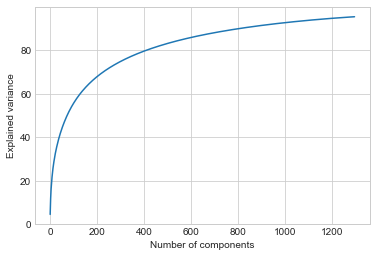

In [26]:
# Scree plot

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')
plt.grid()

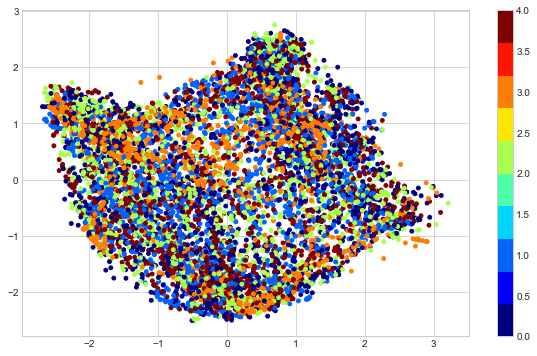

In [22]:
# Scatterplot (train set)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_train[:,0], X_train[:,1], s = 15,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.show()

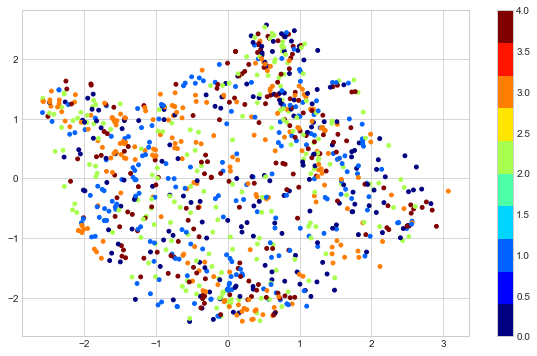

In [23]:
# Scatterplot (test set)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_test[:,0], X_test[:,1], s = 15,
            cmap = c_map , c = y_test)
plt.colorbar()
plt.show()

In [24]:
# Explained Variance

print(pca.explained_variance_)

[1.6532052  1.5528814  1.1228874  ... 0.00245543 0.0024372  0.00243349]


## Reshaping for Use in 2D conv

In [27]:
# dimensions from square root of components after pca

X_train = X_train.reshape(-1, 36, 36, 1)
print(X_train.shape)

X_test = X_test.reshape(-1, 36, 36, 1) 
print(X_test.shape)

(9000, 36, 36, 1)
(1000, 36, 36, 1)


In [28]:
# Encode the labels

y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(9000, 5)
(1000, 5)


In [29]:
print(X_train.shape)
print(X_test.shape)

(9000, 36, 36, 1)
(1000, 36, 36, 1)


## Class Labels

In [30]:
# For class label mapping

class_label = {
    0: 'N - Normal',
    1: 'S - Atrial premature',
    2: 'V - Premature ventricular contraction',
    3: 'F - Fusion of ventricular and normal',
    4: 'Q - Paced Unclassifiable'
}

## Model 2 Definition 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1048640   
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

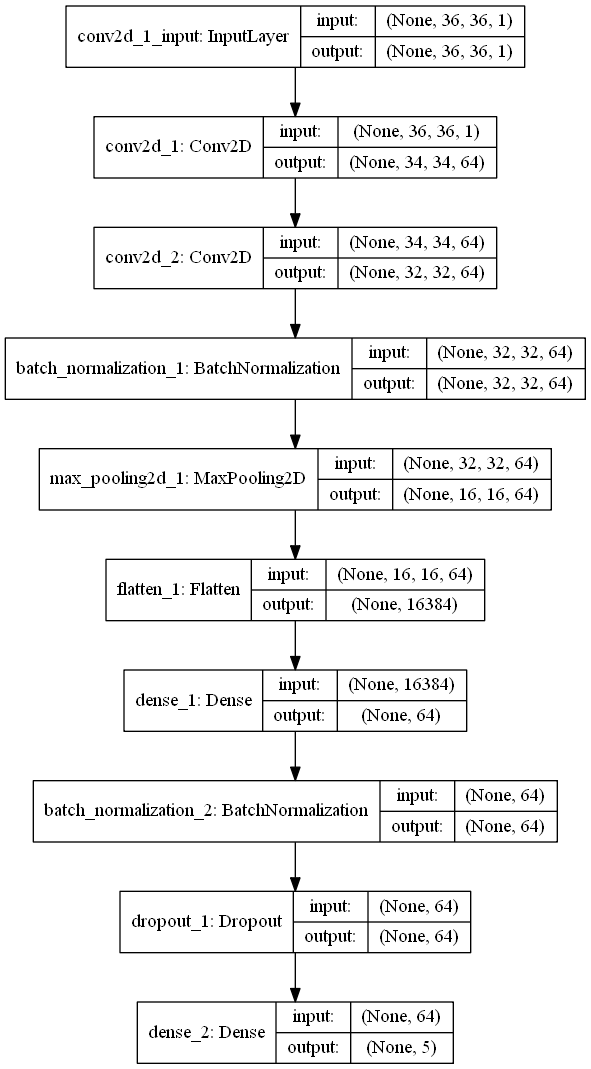

In [31]:
from numpy.random import seed
seed(42)

batch_size = 64  
num_classes = 5 
epochs = 20   
es = EarlyStopping(monitor='val_loss', mode='auto', patience=7, restore_best_weights=True,
 verbose=1)

# Note: Pooling layers can reduce diminsionality too much after PCA and cause an error - Trim if necessary

def create_cnv():
    
    model = Sequential()
    model.add(Conv2D(64,(3,3),activation='elu', input_shape=(36,36,1)))
    model.add(Conv2D(64,(3,3),activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))    
    model.add(Flatten())
    model.add(Dense(64,activation='elu')) 
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    model.add(Dense(5,activation='softmax',))

    model.compile(loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy'])
    return model

model = create_cnv()
model.summary()
plot_model(model, to_file='model_2_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es], 
                  verbose=1,
                  validation_split = 0.1,  
                  validation_data=(X_test, y_test)) 

score = model.evaluate(X_test, y_test, verbose=0)
save_path = "ker_ECG_BEST_2Hidden_128_model.%s.h5" % (score[1])
            
model.save(save_path)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 98s 11ms/step - loss: 0.8711 - accuracy: 0.6743 - val_loss: 2.5881 - val_accuracy: 0.1880
Epoch 2/20
9000/9000 [==============================] - 96s 11ms/step - loss: 0.4144 - accuracy: 0.8532 - val_loss: 2.8112 - val_accuracy: 0.1990
Epoch 3/20
9000/9000 [==============================] - 97s 11ms/step - loss: 0.2245 - accuracy: 0.9246 - val_loss: 1.4403 - val_accuracy: 0.4440
Epoch 4/20
9000/9000 [==============================] - 96s 11ms/step - loss: 0.1408 - accuracy: 0.9544 - val_loss: 0.6119 - val_accuracy: 0.7950
Epoch 5/20
9000/9000 [==============================] - 98s 11ms/step - loss: 0.1018 - accuracy: 0.9703 - val_loss: 0.3932 - val_accuracy: 0.8810
Epoch 6/20
9000/9000 [==============================] - 96s 11ms/step - loss: 0.0762 - accuracy: 0.9773 - val_loss: 0.4667 - val_accuracy: 0.8710
Epoch 7/20
9000/9000 [==============================] - 101s 11ms/step - los

## Saved Model

In [81]:
ls -ltr ker_*

 Volume in drive C is Windows
 Volume Serial Number is 901D-281F

 Directory of C:\Users\celie


 Directory of C:\Users\celie

09/13/2021  02:37 PM         3,410,880 ker_BEST_2Hidden_ECG_28_model.0.8659999966621399.h5
09/08/2021  02:37 PM         1,825,800 ker_BEST_Single_ECG_28_model.0.8610000014305115.h5
09/13/2021  03:17 PM        13,091,024 ker_ECG_BEST_2Hidden_128_model.0.902999997138977.h5
09/10/2021  02:49 PM        14,261,136 ker_ECG_BEST_Single_128_model.0.8769999742507935.h5
               4 File(s)     32,588,840 bytes
               0 Dir(s)  122,887,540,736 bytes free


## Model fitting summary

In [33]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_c2d = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1048640   
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

In [34]:
# Convert labels from one hot encoding for classification report
y_test=np.argmax(y_test, axis=1)
y_test[1]

0

In [35]:
print(classification_report(y_test.astype(int), prediction_c2d))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       188
           1       1.00      0.97      0.98       211
           2       0.85      0.84      0.85       201
           3       1.00      1.00      1.00       215
           4       0.82      0.85      0.84       185

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



Text(0.5, 19.5, 'Predicted Class')

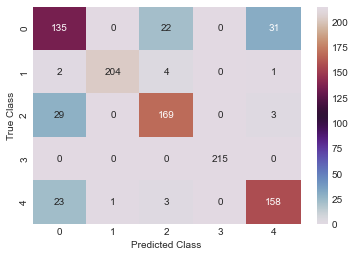

In [36]:
cm = confusion_matrix(y_test,prediction_c2d)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

## Performance metrics from confusion matrix 

In [37]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.93349754 0.99873257 0.96370463 1.         0.95705521]
Specificity Mean: 0.9705979910670568
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.71808511 0.96682464 0.84079602 1.         0.85405405]
Recall/Sensitivity Mean: 0.8759519649774588
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.71428571 0.99512195 0.85353535 1.         0.81865285]
Precision Mean: 0.8763191737563025


## Visualize training and test histories

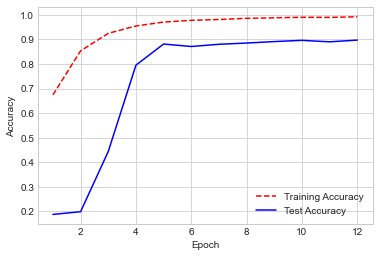

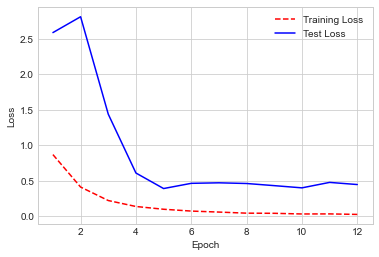

In [38]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [39]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.966687 (macro),
0.967876 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.967824 (macro),
0.969398 (weighted by prevalence)


## ROC plot

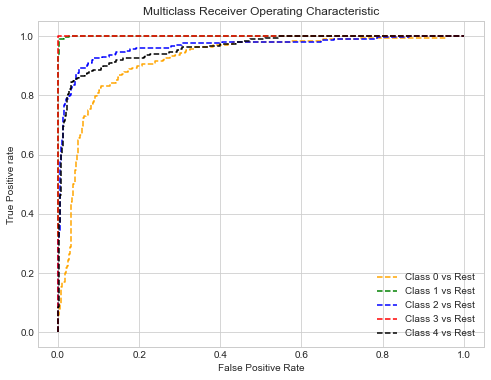

In [40]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

In [41]:
# Predict and plot example

prediction_cplx = model.predict_classes(X_test)
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


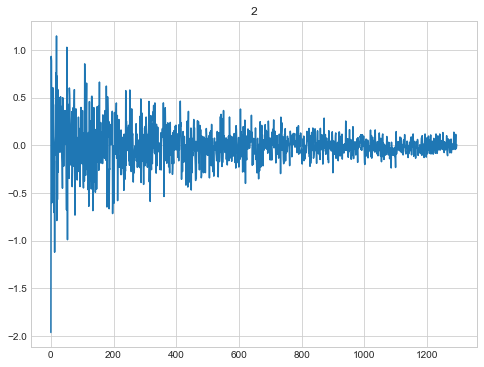

In [42]:
# Test plot

X_test = X_test.reshape(-1,1296) 
#X_test.shape

print('Class:',class_label)
plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8])
#Classes = class_label[y_test[8]]
#plt.xlabel('Components')
#plt.ylabel('Amplitude')
#plt.title(classes)
plt.title( prediction_cplx[8]) 
plt.show()
#plt.grid()